In [1]:
import pandas as pd

Датасет состоит из показов рекламы.

1. date_time - время показа рекламы
2. zone_id - id зоны, где зона - место на сайте для размещения рекламы
3. banner_id - id баннера, где баннер - сама реклама
4. campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
5. os_id - id операционной системы
6. country_id - id страны

8. clicks - был ли клик


In [ ]:
df = pd.read_csv('./data/data.csv', parse_dates=["date_time"], date_parser=pd.to_datetime)
not_needed = ["oaid_hash", "banner_id0", "banner_id1", "rate0",
              "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1", "impressions"]
df.drop(labels=not_needed, axis=1, inplace=True)

##### !!!! ЫЕЩЗ

In [5]:
index = df[(df.date_time.dt.day == 1) & (df.date_time.dt.month == 9)].index
df.drop(index, inplace=True)
print(f"{len(df):_}")  # 15 821 472

df["date"] = df['date_time'].dt.date
df["day"] = df["date_time"].dt.dayofweek
df["time"] = df['date_time'].dt.hour
df.head()

15_821_471


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,day,time
0,2021-09-27 00:01:30,0,0,0,0,0,1,2021-09-27,0,0
1,2021-09-26 22:54:49,1,1,0,0,1,1,2021-09-26,6,22
2,2021-09-26 23:57:20,2,2,3,0,0,1,2021-09-26,6,23
3,2021-09-27 00:04:30,3,3,0,1,1,1,2021-09-27,0,0
4,2021-09-27 00:06:21,4,4,0,1,0,1,2021-09-27,0,0


In [6]:
n_positive = len(df[df["clicks"] == 0])
n_negative = len(df[df["clicks"] == 1])
assert n_positive + n_negative == len(df), "There is other labels in clicks columns"
print(f"Negative labels in dataset : {n_positive:_}\nNegative labels in dataset: {n_negative:_}\n")

Negative labels in dataset : 15_399_222
Negative labels in dataset: 422_249



In [7]:
print("Class's distribution is imbalanced")
weights = dict(df["clicks"].value_counts() / len(df))  # Define weights for logistic regression
df["clicks"].value_counts() / len(df)

Class's distribution is imbalanced


0    0.973312
1    0.026688
Name: clicks, dtype: float64

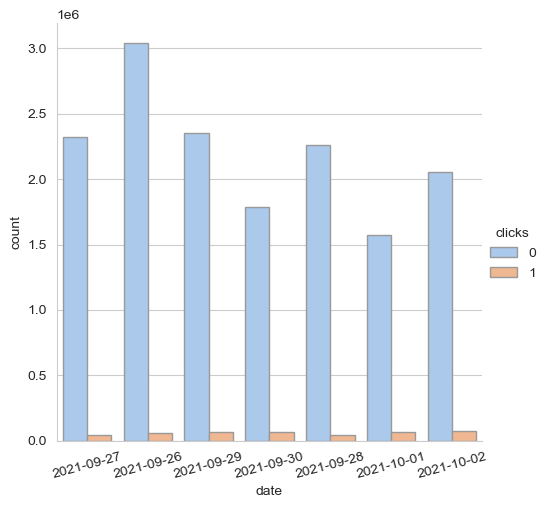

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.catplot(
    data=df, x="date", hue="clicks", kind="count",
    palette="pastel", edgecolor=".6", hue_norm=1
)
plt.xticks(rotation=15)
plt.show();

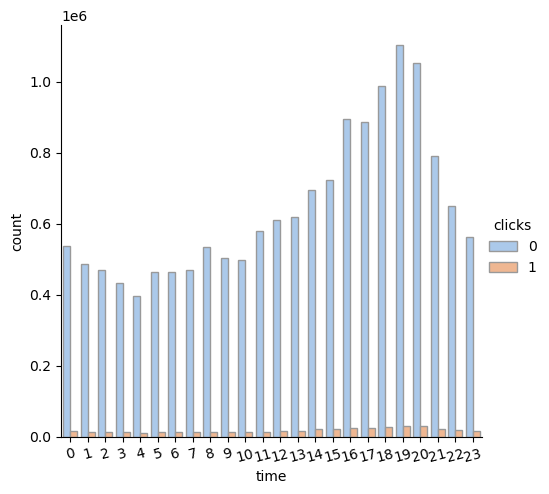

In [87]:
sns.catplot(
    data=df, x="time", hue="clicks", kind="count",
    palette="pastel", edgecolor=".6", hue_norm=(7, 0)
)
plt.xticks(rotation=15)
plt.show();

Check counts of os_id

Похоже, что с некоторых OS никто не кликает на рекламу


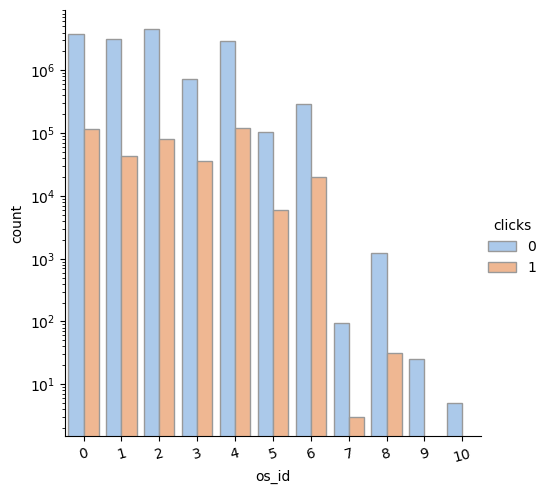

In [98]:
print("Похоже, что с некоторых OS никто не кликает на рекламу")
sns.catplot(
    data=df, x="os_id", hue="clicks", kind="count",
    palette="pastel", edgecolor=".6", log=True
)
plt.xticks(rotation=15)
plt.show();

Check country id

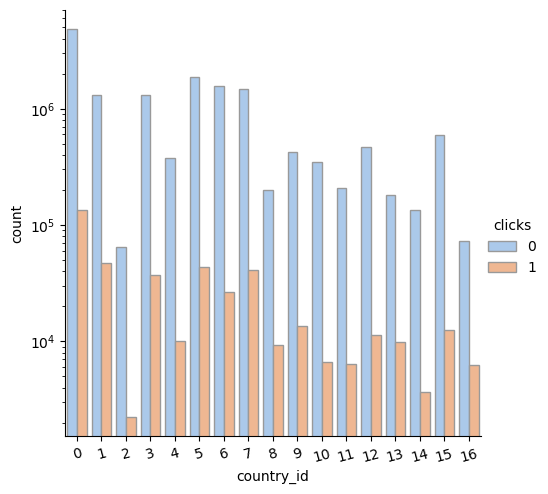

In [102]:
sns.catplot(
    data=df, x="country_id", hue="clicks", kind="count",
    palette="pastel", edgecolor=".6", log=True,
)
plt.xticks(rotation=15)
plt.show();

Возможно день недели будет более информативным признаком

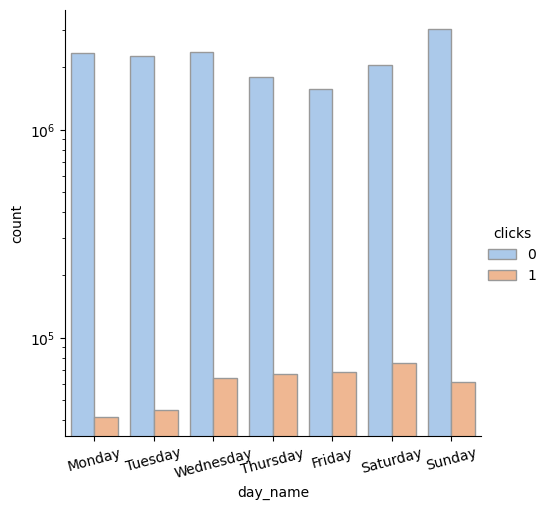

In [128]:
df["day_name"] = df["date_time"].dt.day_name()
sns.catplot(
    data=df, x="day_name", hue="clicks", kind="count",
    palette="pastel", edgecolor=".6", log=True,
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xticks(rotation=15)
plt.show();

In [177]:
df['log_clicks'] = np.log(df['campaign_clicks'] + 1e-5)

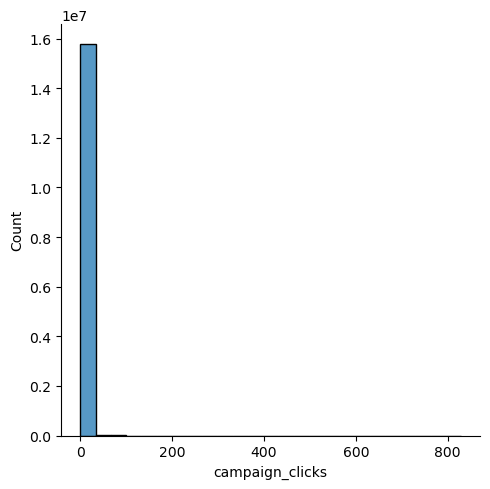

In [168]:
sns.displot(df["campaign_clicks"]);

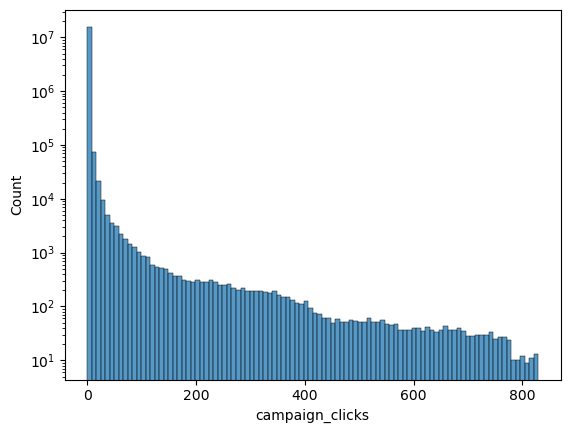

In [176]:
sns.histplot(df["campaign_clicks"] + 1e-5, log=True, bins=100);

Я построила несколько графиков, чтобы ознакомиться с данными и посмотреть есть ли среди них фичи с хорошей разделяющей способностью. Что удалось узнать:
   1. Выборка имеет несбалансированность по классам, поэтому я попоробую обучить лог регрессию с взвешенными классами.
   2. Люди меньше кликают на рекламу в начале недели и этот показатель увеличивается постепенно к концу.
   3. Переменную кликов пришлось логарифмировать, т к она содержала слишком большие значения в маленьком колве наблюдений. Так что можно посмотреть в этом случае на относительное изменение.
   4. Хотелось бы конечно уменьшить количество категорий и попробовать различные техники бининга. Но в следующий раз.

# Подготовим трейн и тест

In [8]:
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


def feature_engineering(df: pd.DataFrame) -> tuple[np.array, np.array, np.array, np.array, dict]:
    # Delete
    index = df[(df.date_time.dt.day == 1) & (df.date_time.dt.month == 9)].index
    df.drop(index, inplace=True)
    print(f"Dataset samples {len(df):_}")  # 15 821 472

    df["date"] = df['date_time'].dt.date
    df["day"] = df["date_time"].dt.dayofweek
    df["time"] = df['date_time'].dt.hour

    df['log_clicks'] = np.log(df['campaign_clicks'] + 1e-5)

    train_set = df[df["date_time"].dt.date < pd.to_datetime('2021-10-02')]
    test_set = df[df["date_time"].dt.date == pd.to_datetime('2021-10-02')]

    # ONE HOT encoding
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore', sparse=True, drop='first')
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id', 'time', 'day']
    x_categorical_train = enc.fit_transform(train_set[categorical_features])
    x_categorical_test = enc.transform(test_set[categorical_features])

    # Prepare features matrix
    from scipy.sparse import hstack
    x_train = hstack((x_categorical_train, np.array(train_set["log_clicks"])[:, np.newaxis]))
    x_test = hstack((x_categorical_test, np.array(test_set["log_clicks"])[:, np.newaxis]))
    assert x_test.shape[1] == x_train.shape[1], "Number of features in train and test must be equal"

    # Prepare labels
    y_train, y_test = train_set["clicks"], test_set["clicks"]
    assert y_test.shape[0] == x_test.shape[0], "Number of observation in train and test must be equal"
    assert y_train.shape[0] == x_train.shape[0], "Number of observation in train and test must be equal"

    # Prepare weights
    weights = dict(train_set['clicks'].value_counts())

    return x_train, y_train, x_test, y_test, weights

In [9]:
x_train, y_train, x_test, y_test, weights = feature_engineering(df)

Dataset samples 15_821_471


In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, weights

((13692493, 4969),
 (13692493,),
 (2128978, 4969),
 (2128978,),
 {0: 13345606, 1: 346887})

# Модель и крос валидация

In [16]:
from sklearn.linear_model import LogisticRegression


def create_model(w=None):
    if weights is not None:
        log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight=w)
    else:
        log_reg = LogisticRegression(solver='liblinear', random_state=42)
    return log_reg

In [18]:
from sklearn.model_selection import GridSearchCV


def cv(x_train, y_train, w=None):
    model = create_model(w)
    param_search = {'C': [0.001, 0.01, 0.1]}
    gsearch = GridSearchCV(estimator=model, cv=3, param_grid=param_search, verbose=2,
                           scoring=["neg_log_loss", "roc_auc"], refit="neg_log_loss")
    gsearch.fit(x_train, y_train)
    best_model = gsearch.best_estimator_
    return best_model.fit(x_train, y_train)


model = cv(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ............................................C=0.001; total time=  22.7s
[CV] END ............................................C=0.001; total time=  22.5s
[CV] END ............................................C=0.001; total time=  20.4s
[CV] END .............................................C=0.01; total time=  34.2s
[CV] END .............................................C=0.01; total time=  34.4s
[CV] END .............................................C=0.01; total time=  30.5s
[CV] END ..............................................C=0.1; total time=  51.4s
[CV] END ..............................................C=0.1; total time= 1.1min
[CV] END ..............................................C=0.1; total time= 1.0min


In [27]:
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np


baseline = np.full(y_test.shape, np.mean(y_test))
results_roc = round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]), 3)
results_loss = round(log_loss(y_test, model.predict_proba(x_test)), 3)
print(f'Best model : {results_roc}, {results_loss}')
print(f'Baseline: {round(roc_auc_score(y_test, baseline), 3)}, {round(log_loss(y_test, baseline), 3)}')

Best model : 0.769, 0.137
Baseline: 0.5, 0.153


In [29]:
model = cv(x_train, y_train, w=weights)

baseline = np.full(y_test.shape, np.mean(y_test))
results_roc = round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]), 3)
results_loss = round(log_loss(y_test, model.predict_proba(x_test)), 3)
print(f'Best model : {results_roc}, {results_loss}')
print(f'Baseline: {round(roc_auc_score(y_test, baseline), 3)}, {round(log_loss(y_test, baseline), 3)}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ............................................C=0.001; total time=  36.0s
[CV] END ............................................C=0.001; total time=  41.1s
[CV] END ............................................C=0.001; total time=  32.7s
[CV] END .............................................C=0.01; total time=  39.1s
[CV] END .............................................C=0.01; total time=  30.5s
[CV] END .............................................C=0.01; total time=  28.4s
[CV] END ..............................................C=0.1; total time=  31.9s
[CV] END ..............................................C=0.1; total time=  34.5s
[CV] END ..............................................C=0.1; total time=  28.1s
Best model : 0.776, 0.238
Baseline: 0.5, 0.153


# Выводы:
### Как можно видеть взвешивание классов действительно дало свои результаты.